<a href="https://colab.research.google.com/github/t111368544/lab4/blob/main/1111_%E4%BA%BA%E5%B7%A5%E6%99%BA%E6%85%A7%E5%9C%A8%E8%B3%87%E9%80%9A%E8%A8%8A%E6%8A%80%E8%A1%93%E6%87%89%E7%94%A8%E5%AF%A6%E5%8B%99_307924_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 目標資料夾

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
path="/content/drive/MyDrive/人工智慧在資通訊技術應用實務_307924_lab4"
os.chdir(path)
os.listdir(path)

['logs', 'tst_full_code_v1.py', 'rnn22.py']

In [ ]:
!ls /content/drive/MyDrive/人工智慧在資通訊技術應用實務_307924_lab4

logs  rnn22.py	tst_full_code_v1.py


# import( tensorflow有指定版本)

In [ ]:
!pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.3.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.2.0
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.10.3
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.9
bokeh

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


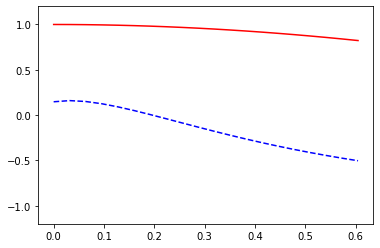

cost:  25.354


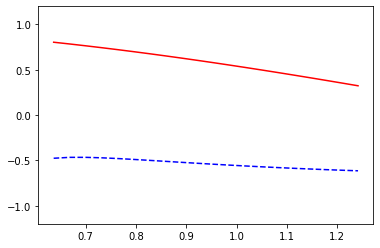

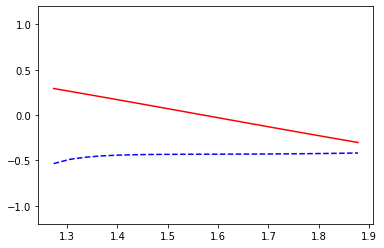

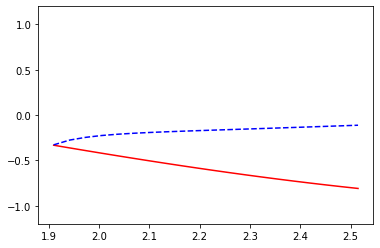

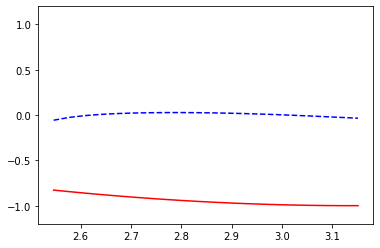

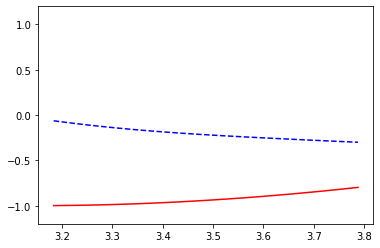

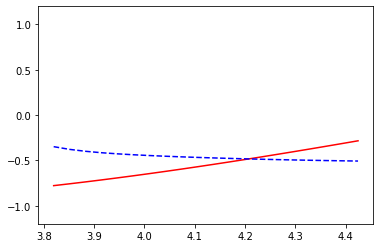

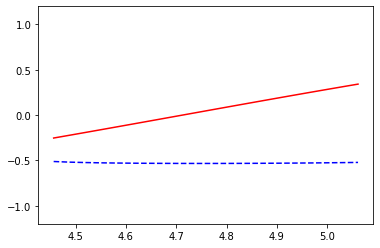

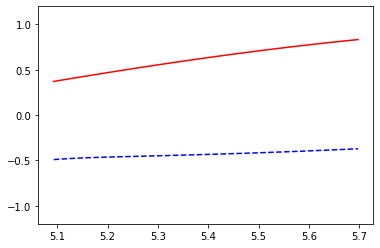

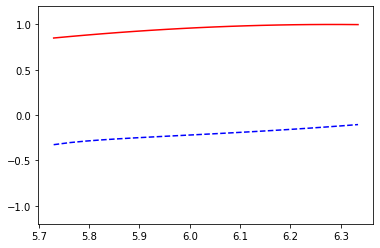

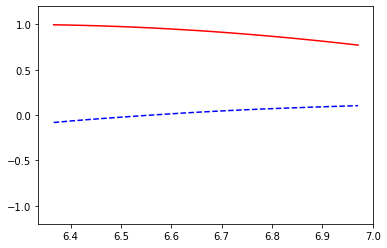

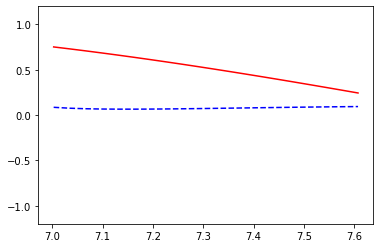

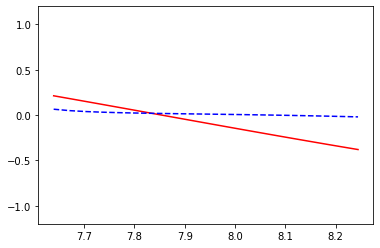

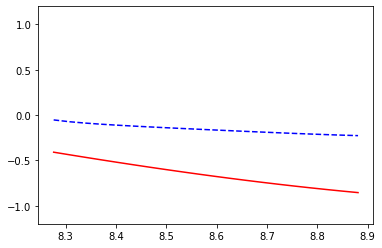

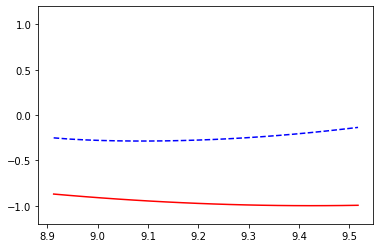

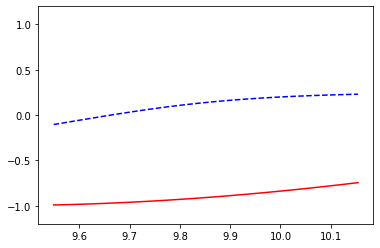

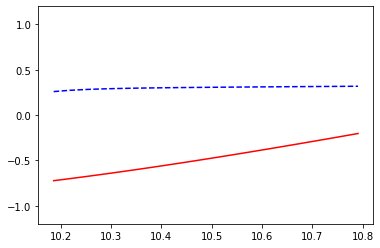

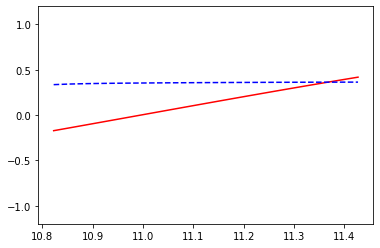

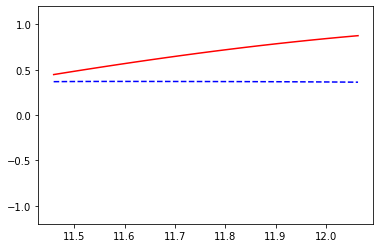

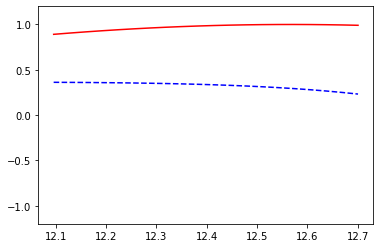

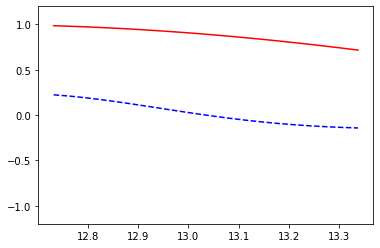

cost:  8.292


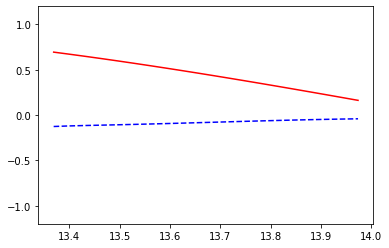

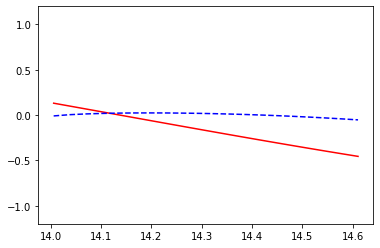

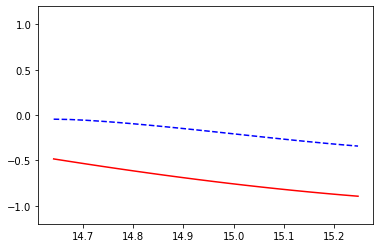

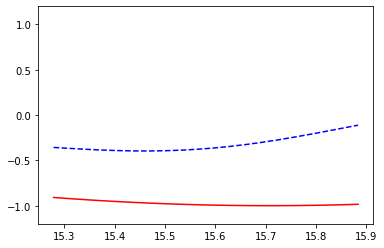

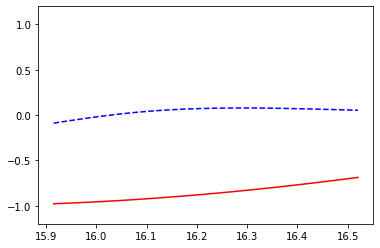

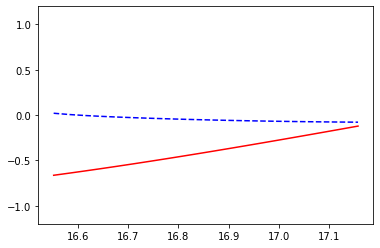

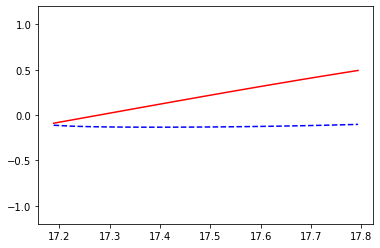

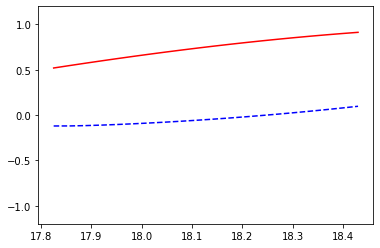

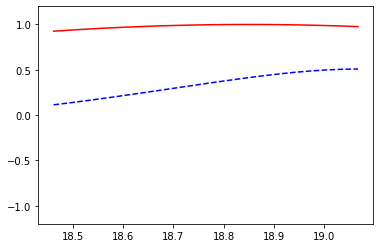

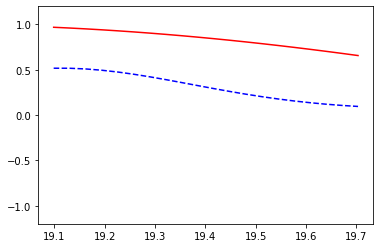

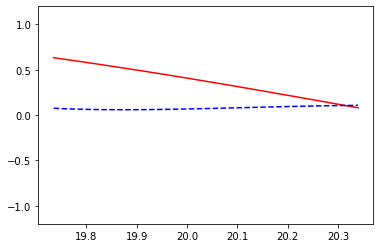

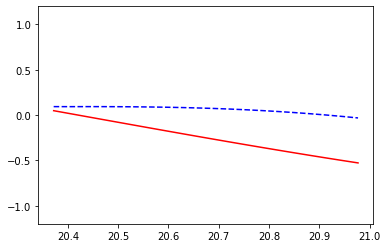

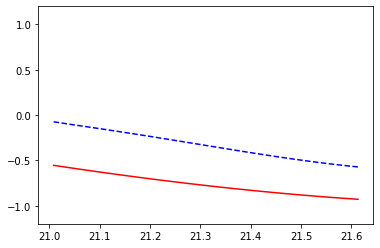

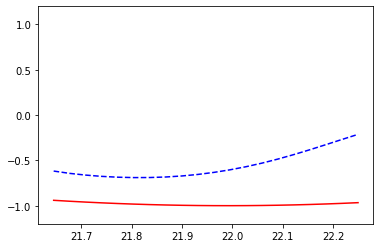

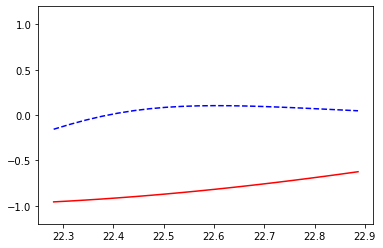

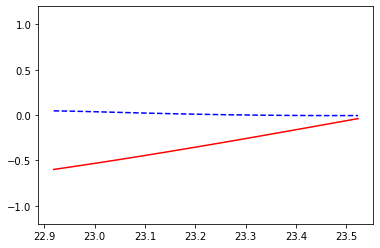

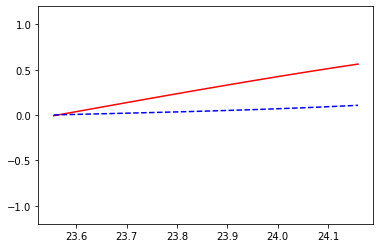

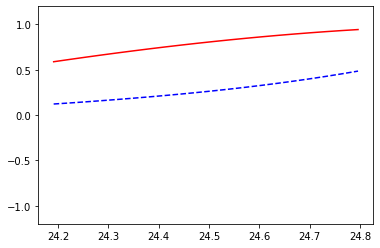

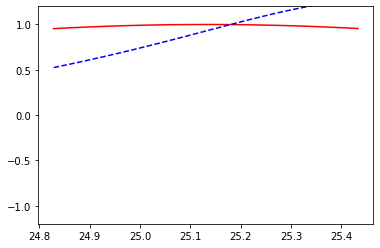

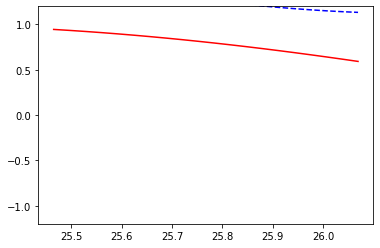

cost:  7.3346


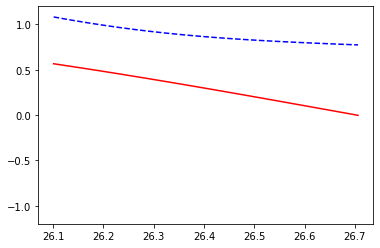

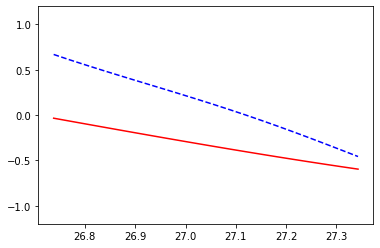

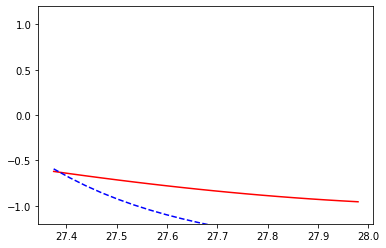

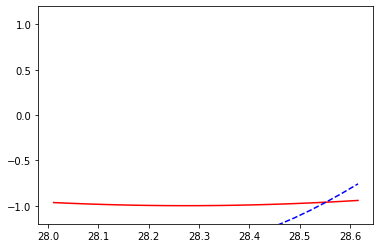

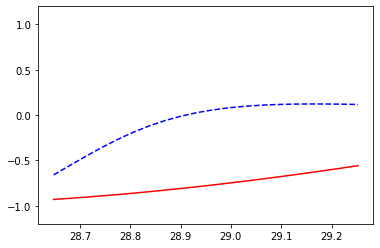

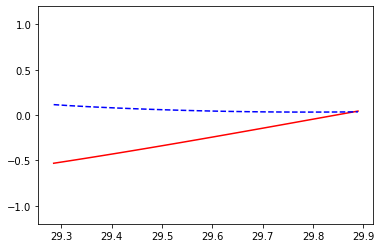

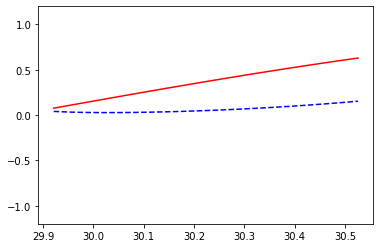

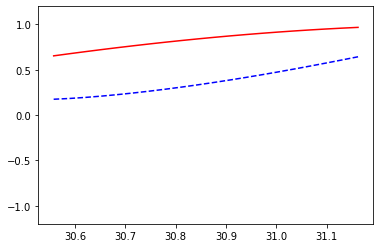

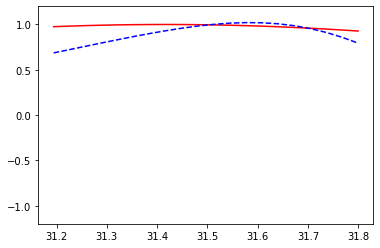

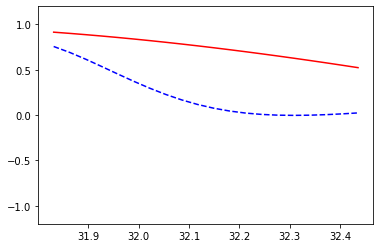

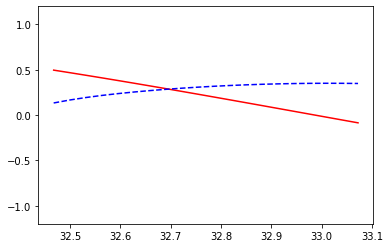

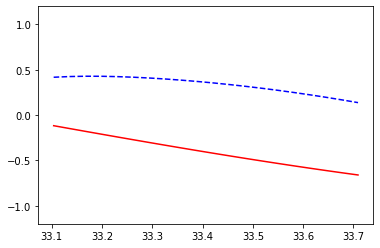

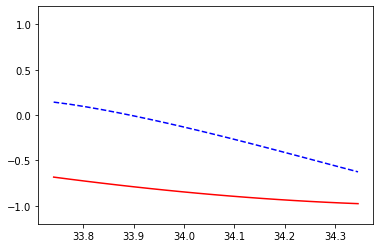

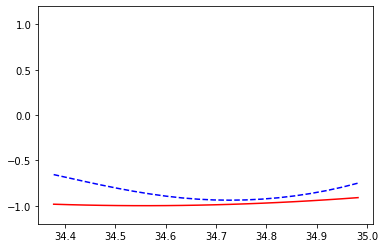

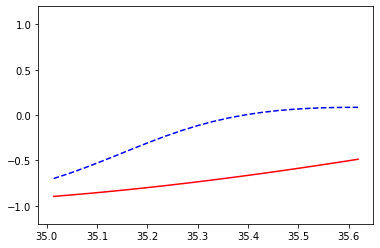

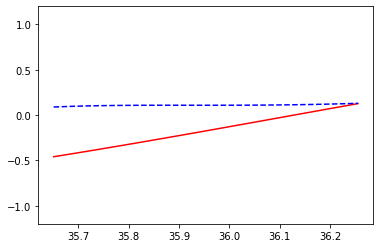

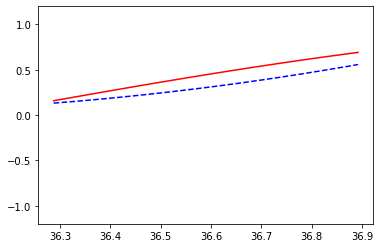

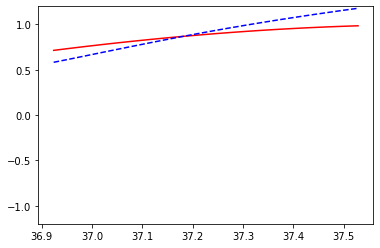

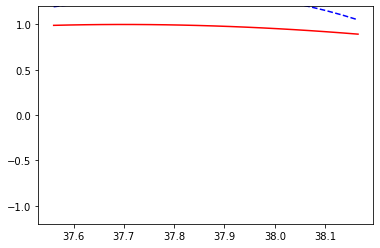

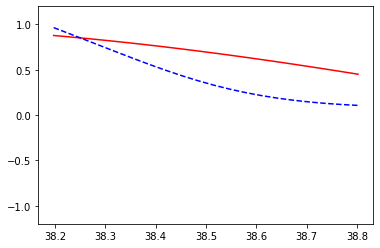

cost:  1.6399


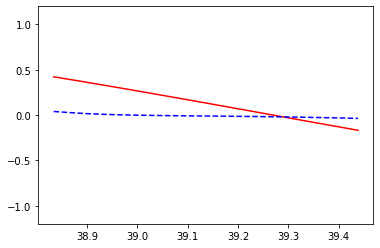

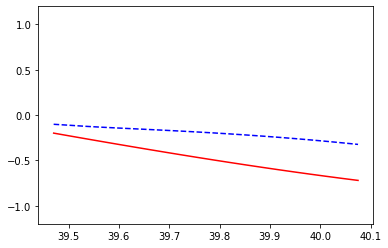

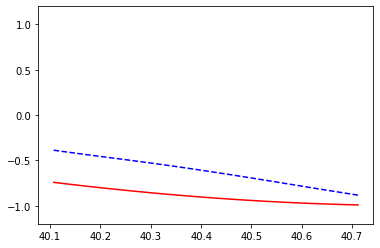

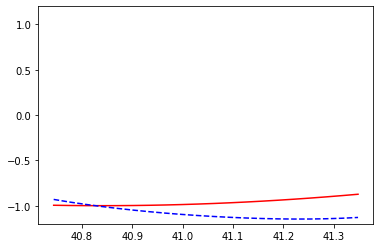

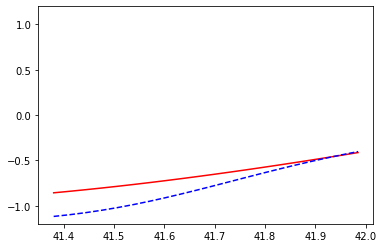

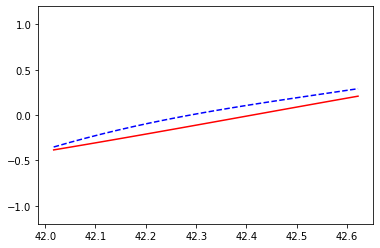

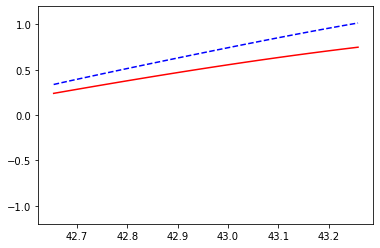

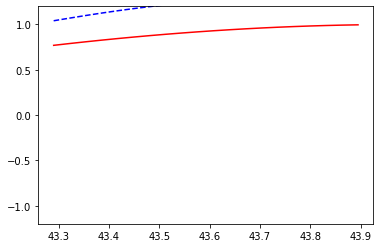

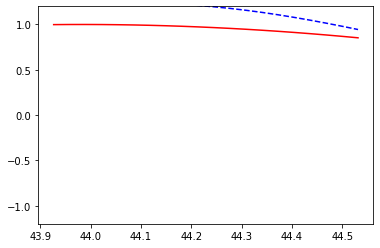

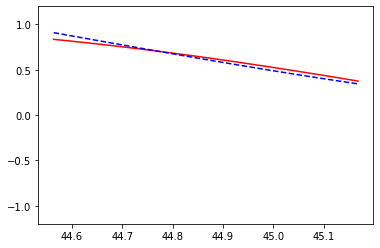

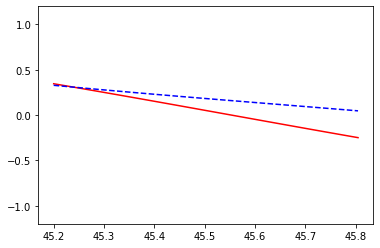

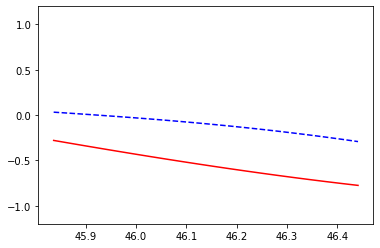

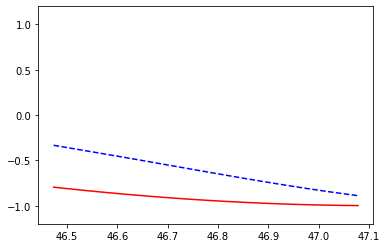

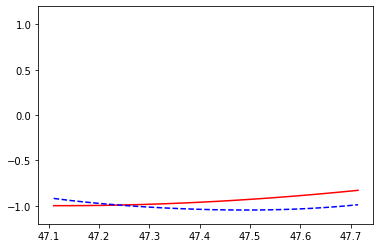

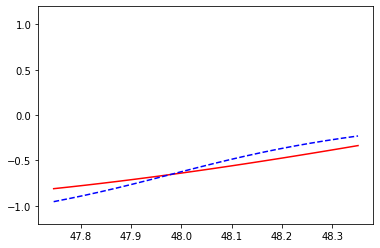

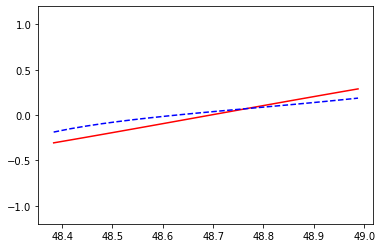

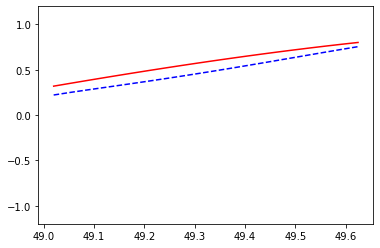

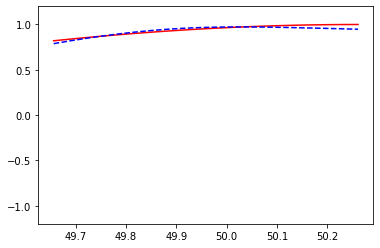

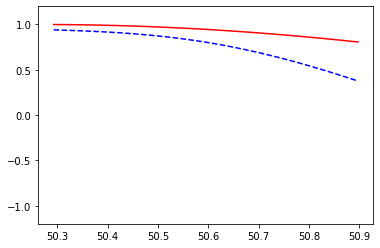

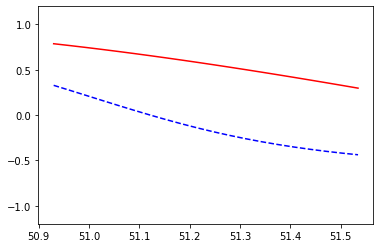

cost:  2.1221


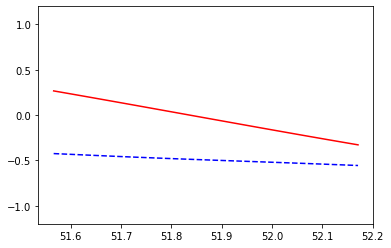

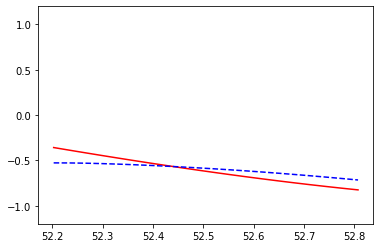

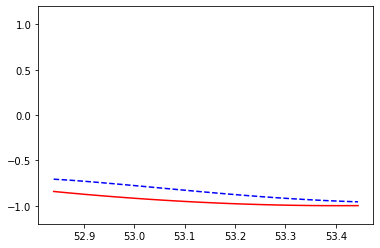

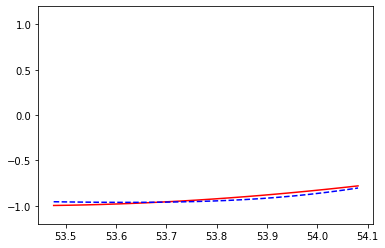

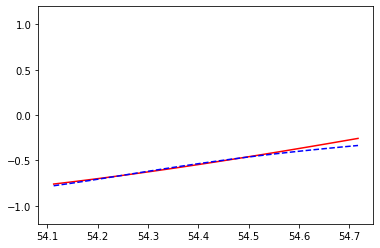

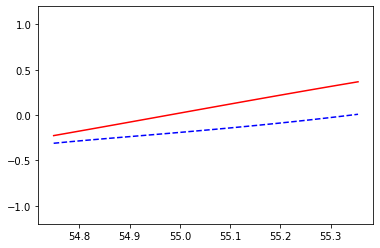

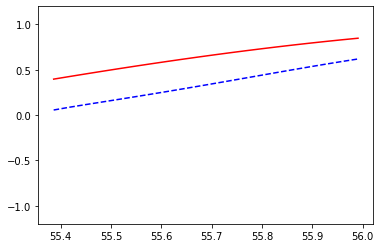

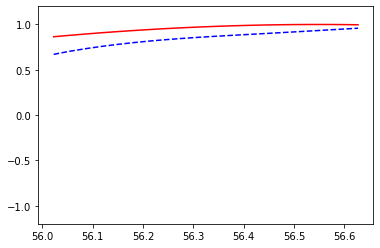

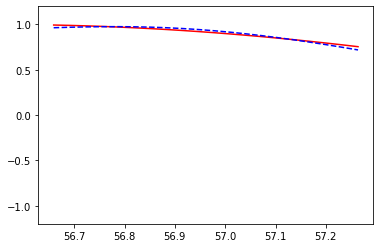

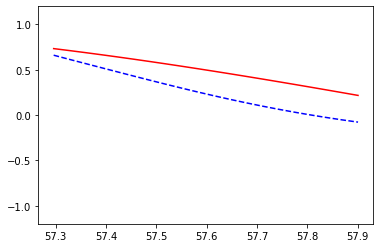

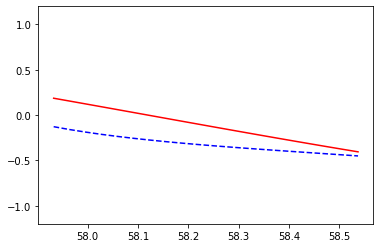

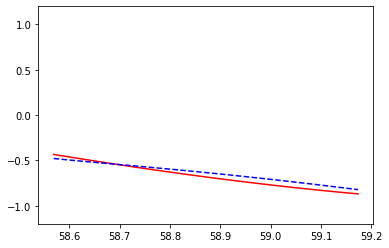

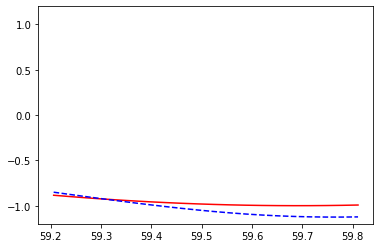

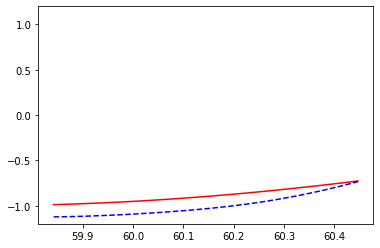

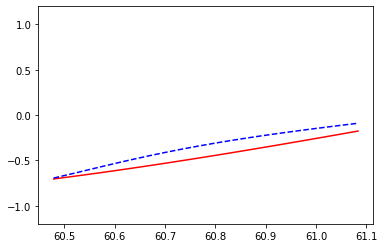

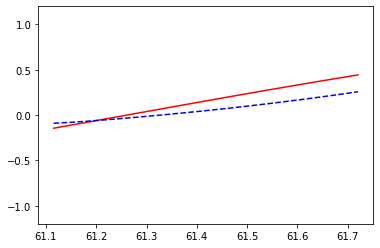

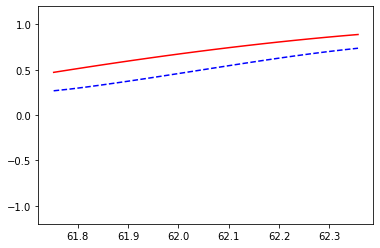

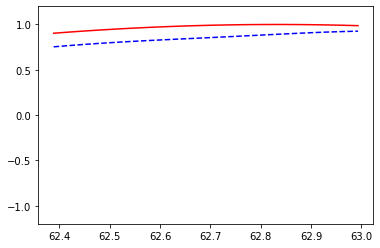

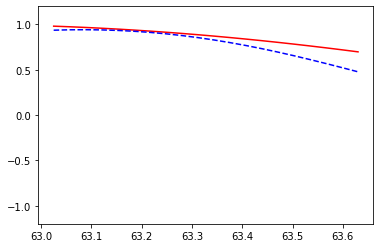

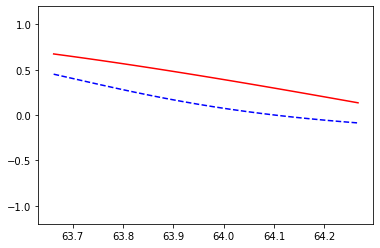

cost:  0.9004


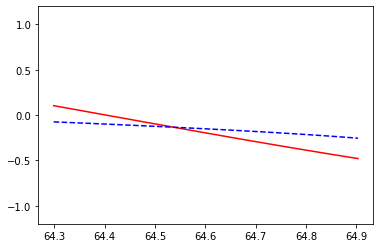

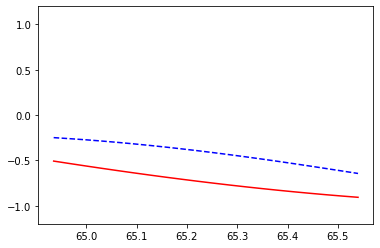

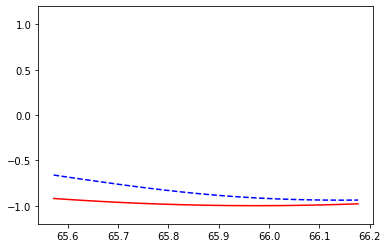

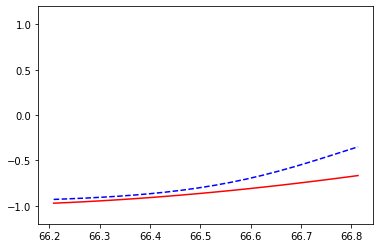

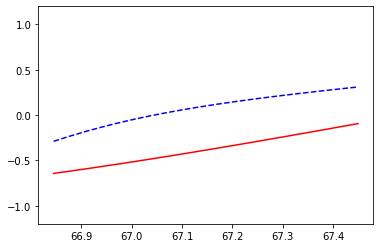

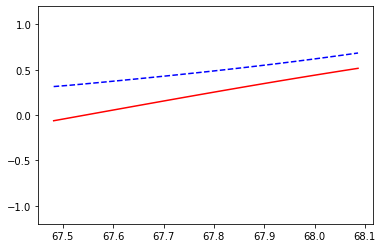

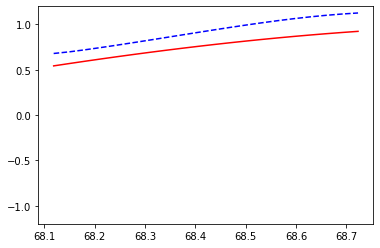

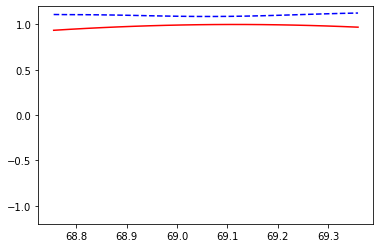

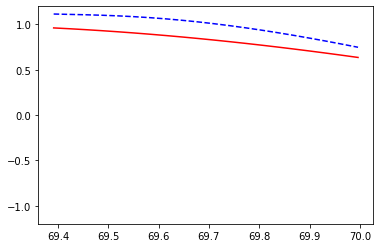

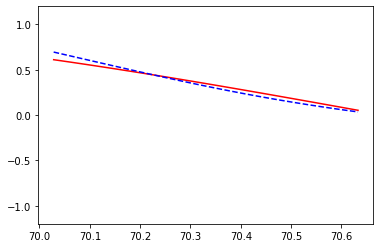

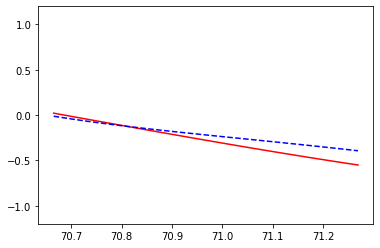

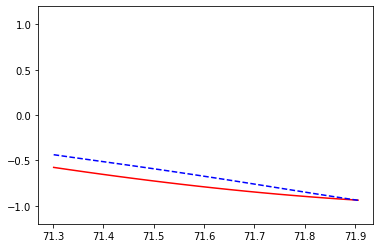

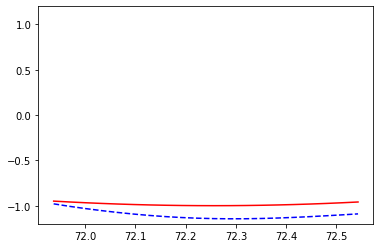

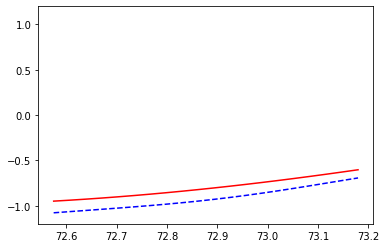

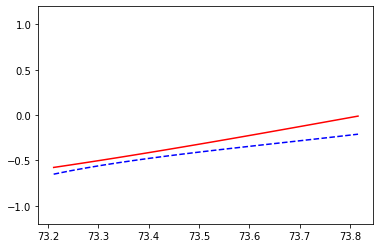

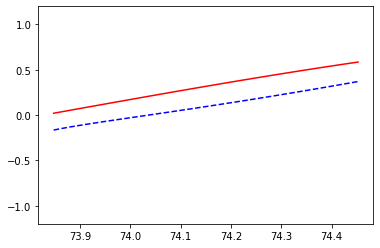

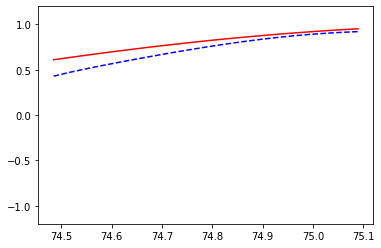

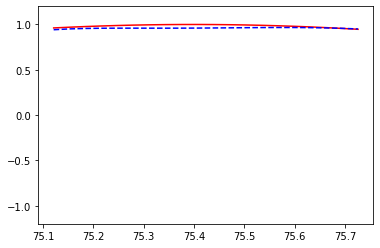

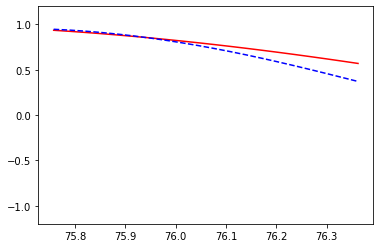

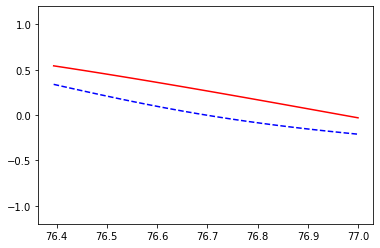

cost:  0.3232


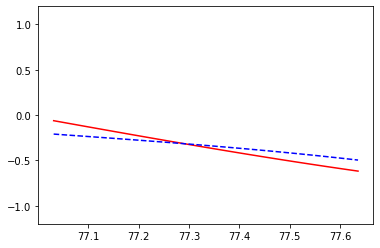

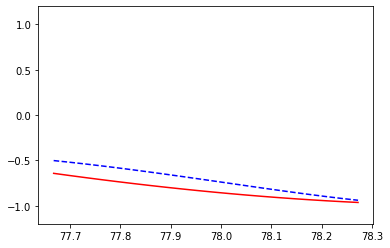

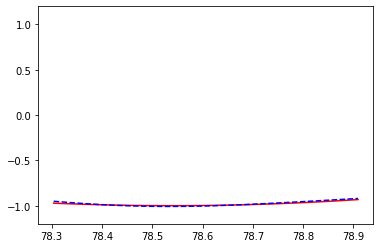

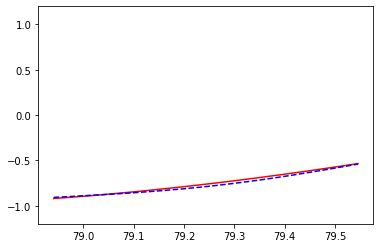

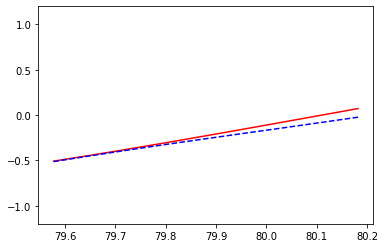

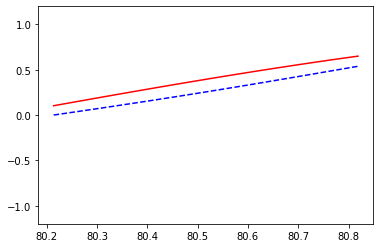

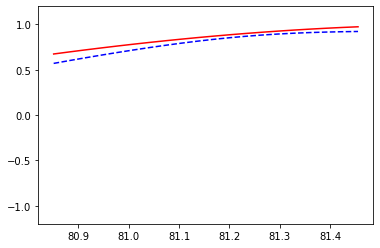

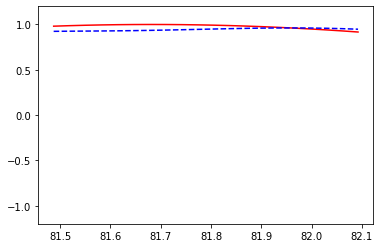

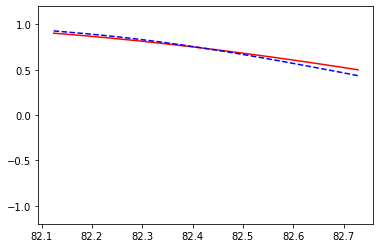

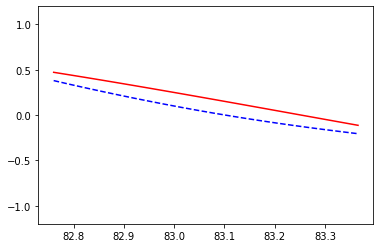

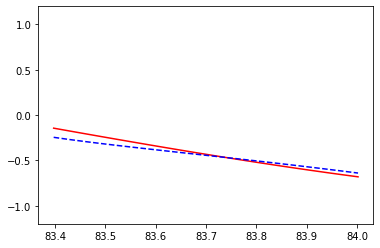

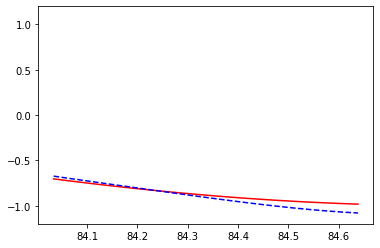

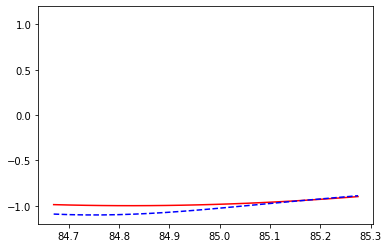

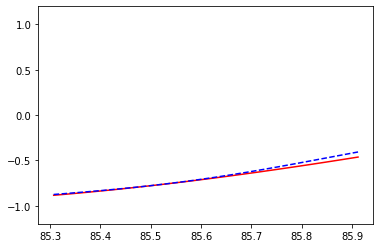

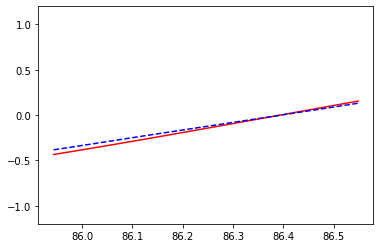

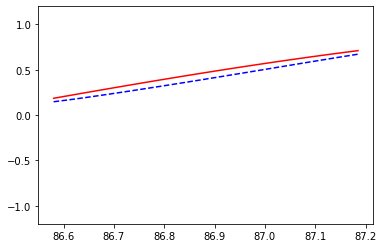

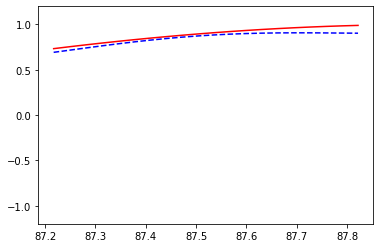

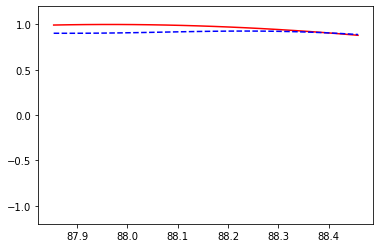

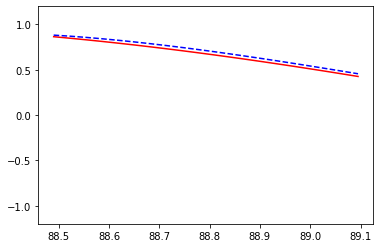

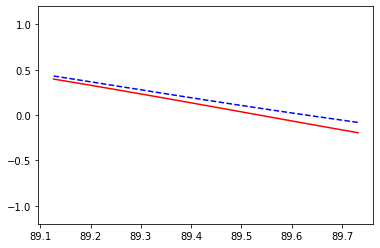

cost:  0.1916


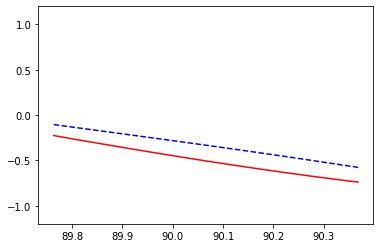

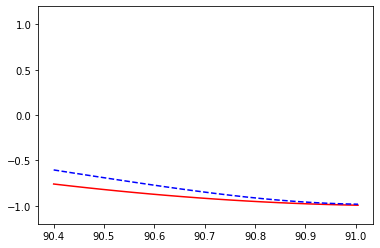

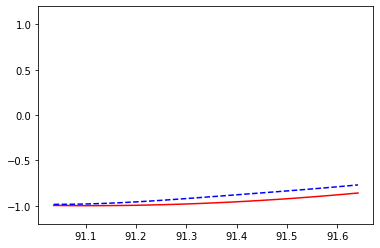

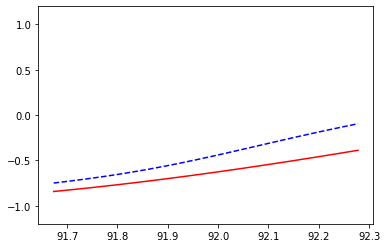

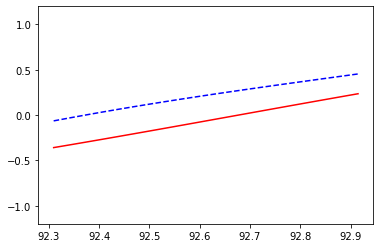

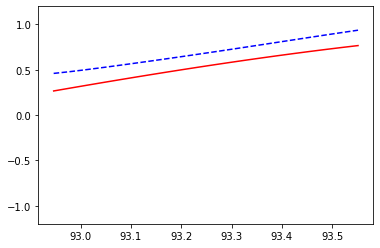

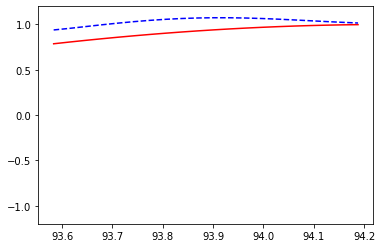

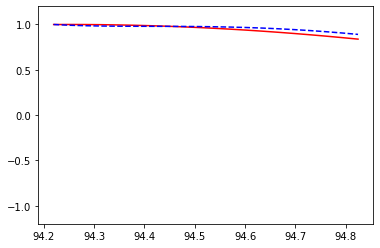

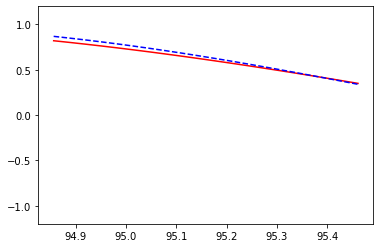

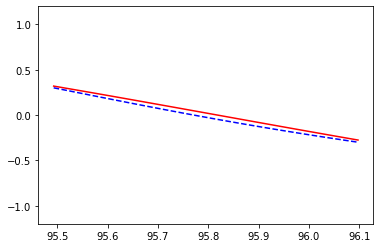

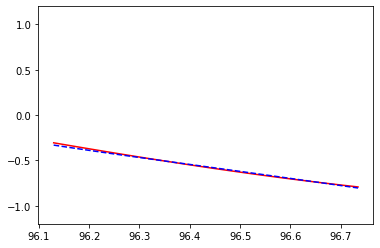

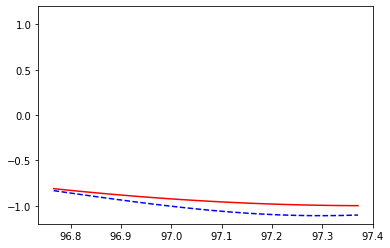

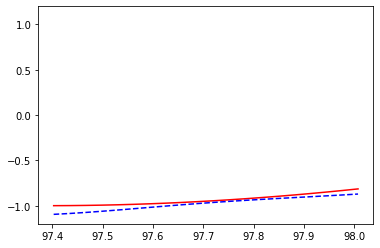

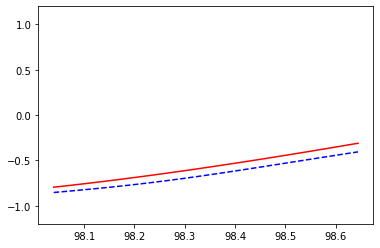

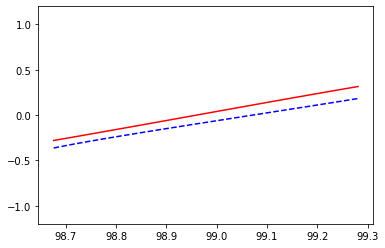

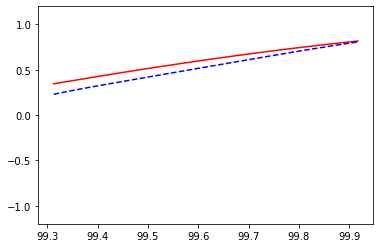

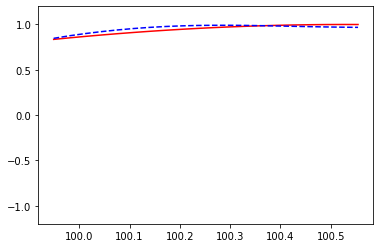

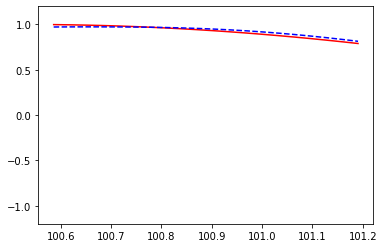

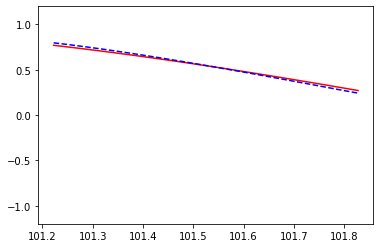

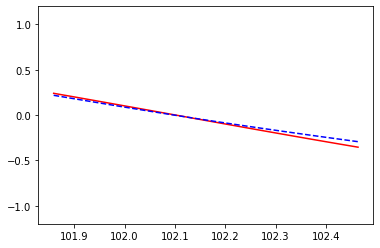

cost:  0.1328


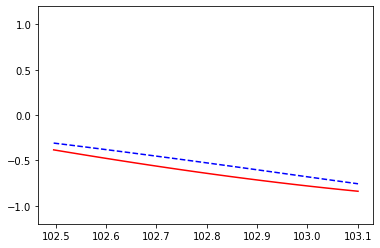

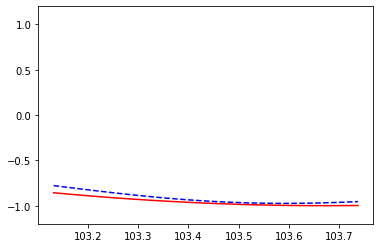

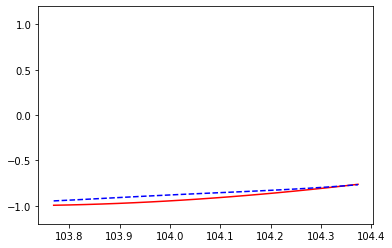

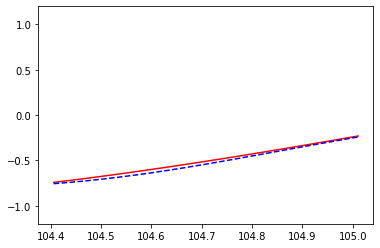

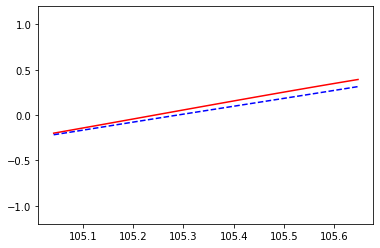

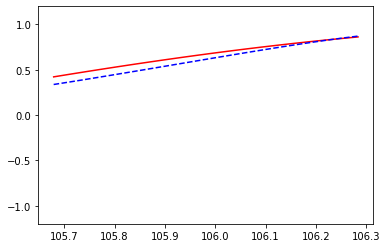

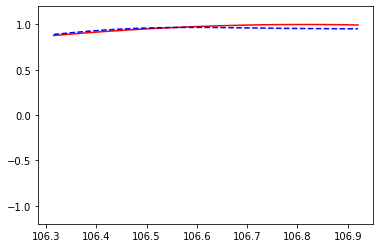

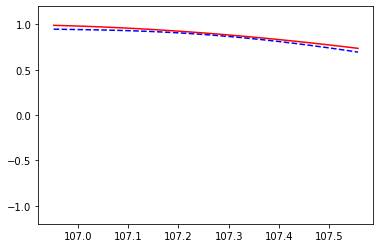

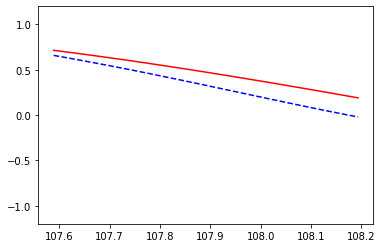

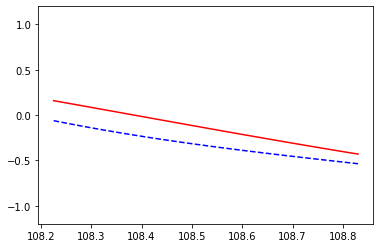

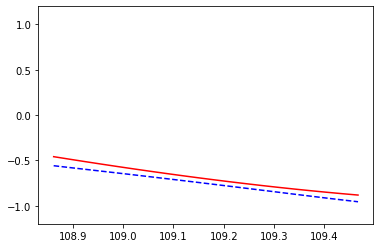

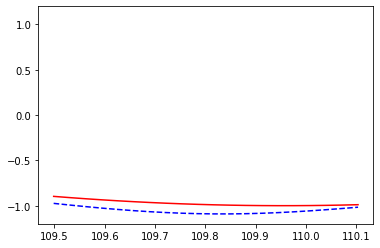

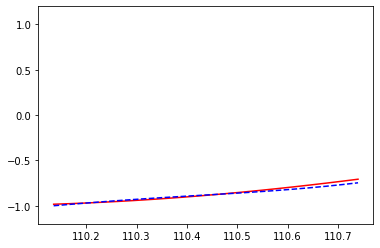

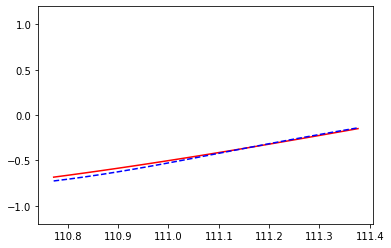

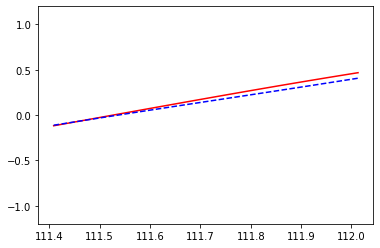

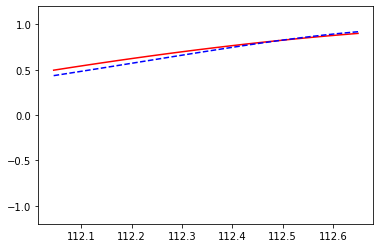

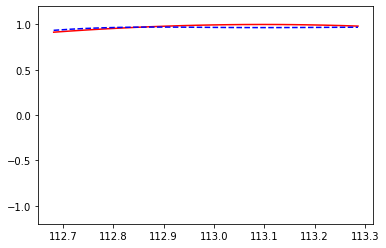

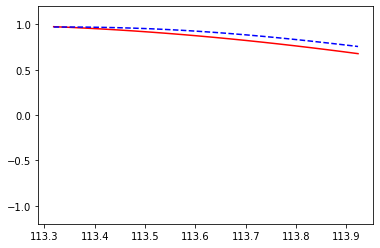

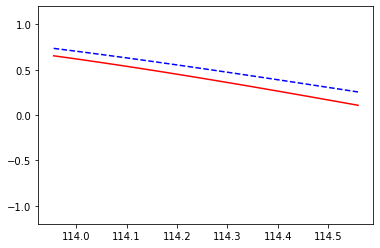

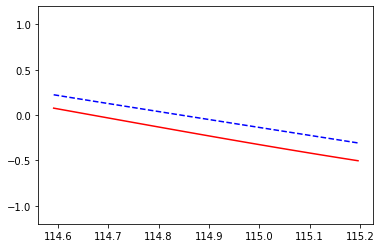

cost:  0.1587


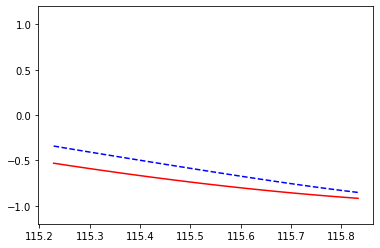

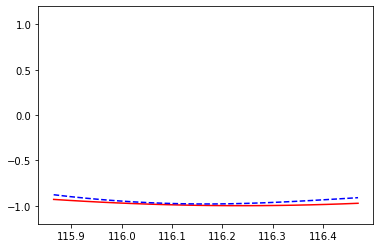

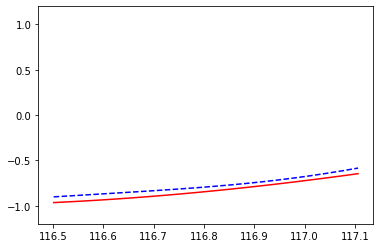

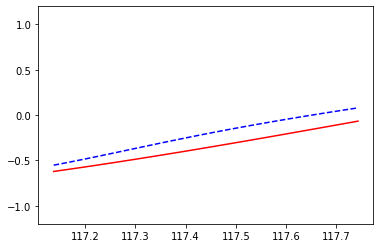

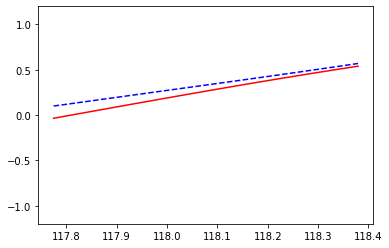

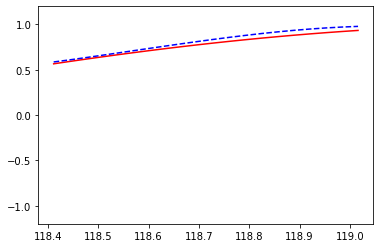

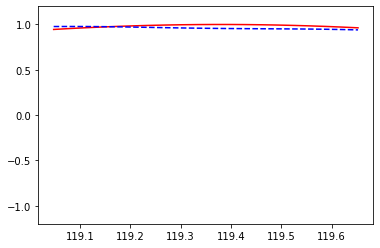

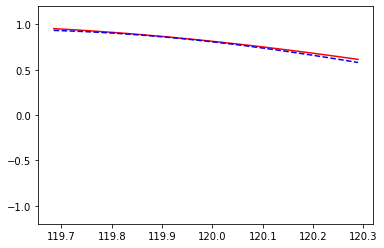

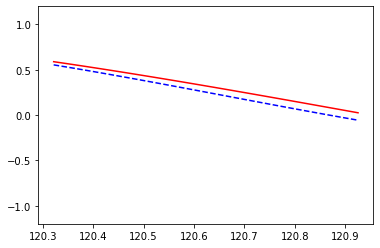

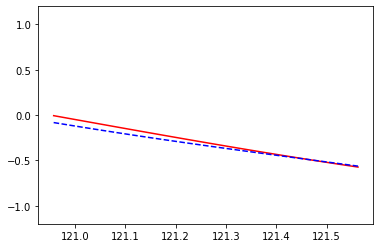

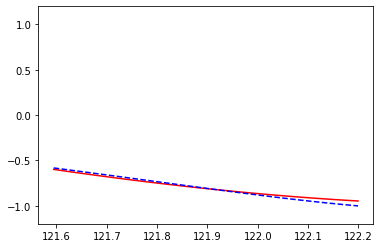

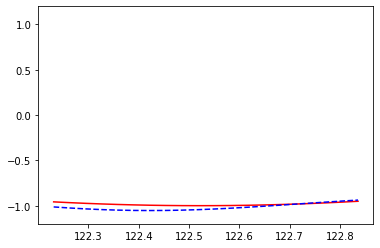

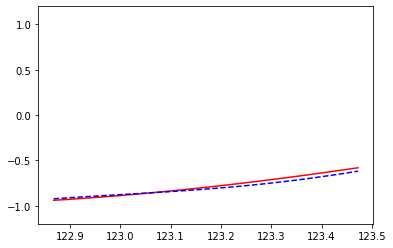

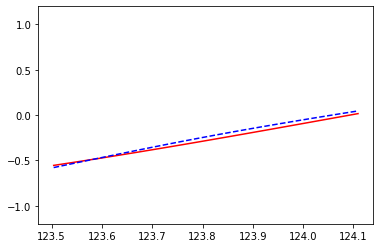

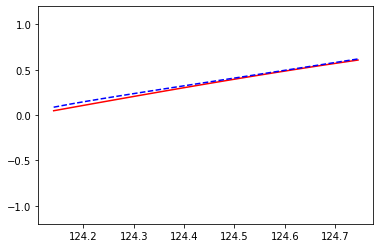

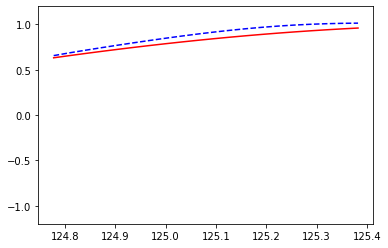

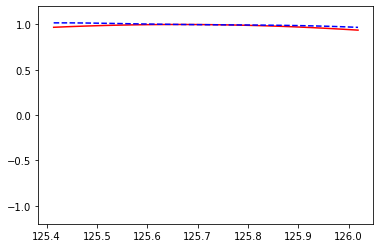

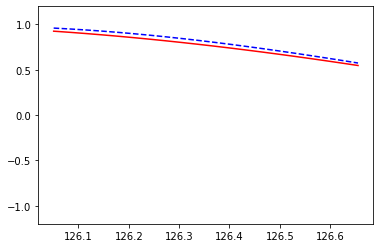

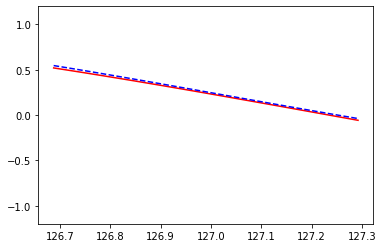

In [ ]:
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import matplotlib.pyplot as plt


BATCH_START = 0
TIME_STEPS = 20
BATCH_SIZE = 50
INPUT_SIZE = 1
OUTPUT_SIZE = 1
CELL_SIZE = 10
LR = 0.006


def get_batch():
    global BATCH_START, TIME_STEPS
    # xs shape (50batch, 20steps)
    xs = np.arange(BATCH_START, BATCH_START+TIME_STEPS*BATCH_SIZE).reshape((BATCH_SIZE, TIME_STEPS)) / (10*np.pi)
    seq = np.sin(xs)

    # privide same pattern as sin
    res = np.cos(xs)

    # given sin is working too
    # res = np.sin(xs)

    BATCH_START += TIME_STEPS
    # plt.plot(xs[0, :], res[0, :], 'r', xs[0, :], seq[0, :], 'b--')
    # plt.show()
    # returned seq, res and xs: shape (batch, step, input)
    return [seq[:, :, np.newaxis], res[:, :, np.newaxis], xs]


class LSTMRNN(object):
    def __init__(self, n_steps, input_size, output_size, cell_size, batch_size):
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size
        self.batch_size = batch_size
        with tf.name_scope('inputs'):
            self.xs = tf.placeholder(tf.float32, [None, n_steps, input_size], name='xs')
            self.ys = tf.placeholder(tf.float32, [None, n_steps, output_size], name='ys')
        with tf.variable_scope('in_hidden'):
            self.add_input_layer()
        with tf.variable_scope('LSTM_cell'):
            self.add_cell()
        with tf.variable_scope('out_hidden'):
            self.add_output_layer()
        with tf.name_scope('cost'):
            self.compute_cost()
        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(LR).minimize(self.cost)

    def add_input_layer(self,):
        l_in_x = tf.reshape(self.xs, [-1, self.input_size], name='2_2D')  # (batch*n_step, in_size)
        # Ws (in_size, cell_size)
        Ws_in = self._weight_variable([self.input_size, self.cell_size])
        # bs (cell_size, )
        bs_in = self._bias_variable([self.cell_size,])
        # l_in_y = (batch * n_steps, cell_size)
        with tf.name_scope('Wx_plus_b'):
            l_in_y = tf.matmul(l_in_x, Ws_in) + bs_in
        # reshape l_in_y ==> (batch, n_steps, cell_size)
        self.l_in_y = tf.reshape(l_in_y, [-1, self.n_steps, self.cell_size], name='2_3D')

    def add_cell(self):
        lstm_cell = rnn.BasicLSTMCell(self.cell_size, forget_bias=1.0, state_is_tuple=True)
        with tf.name_scope('initial_state'):
            self.cell_init_state = lstm_cell.zero_state(self.batch_size, dtype=tf.float32)
        self.cell_outputs, self.cell_final_state = tf.nn.dynamic_rnn(
            lstm_cell, self.l_in_y, initial_state=self.cell_init_state, time_major=False)

    def add_output_layer(self):
        # shape = (batch * steps, cell_size)
        l_out_x = tf.reshape(self.cell_outputs, [-1, self.cell_size], name='2_2D')
        Ws_out = self._weight_variable([self.cell_size, self.output_size])
        bs_out = self._bias_variable([self.output_size, ])
        # shape = (batch * steps, output_size)
        with tf.name_scope('Wx_plus_b'):
            self.pred = tf.matmul(l_out_x, Ws_out) + bs_out

    def compute_cost(self):
        with tf.name_scope('average_cost'):
            self.cost = tf.div(
                tf.reduce_sum(self.ms_error(
                   tf.reshape(self.pred, [-1], name='reshape_pred'),
                   tf.reshape(self.ys,   [-1], name='reshape_target')), name='losses_sum'),
                self.batch_size,
                name='average_cost')
            tf.summary.scalar('cost', self.cost)

    def ms_error(self, y_pre, y_target):
        return tf.square(tf.subtract(y_pre, y_target))

    def _weight_variable(self, shape, name='weights'):
        initializer = tf.random_normal_initializer(mean=0., stddev=1.,)
        return tf.get_variable(shape=shape, initializer=initializer, name=name)

    def _bias_variable(self, shape, name='biases'):
        initializer = tf.constant_initializer(0.1)
        return tf.get_variable(name=name, shape=shape, initializer=initializer)


if __name__ == '__main__':
    model = LSTMRNN(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE, CELL_SIZE, BATCH_SIZE)
    sess = tf.Session()
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("logs", sess.graph)
    # tf.initialize_all_variables() no long valid
    sess.run(tf.global_variables_initializer())
    # relocate to the local dir and run this line to view it on Chrome (http://0.0.0.0:6006/):
    # $ tensorboard --logdir='logs'

    plt.ion()
    plt.show()
    for i in range(200):
        seq, res, xs = get_batch()
        if i == 0:
            feed_dict = {
                    model.xs: seq,
                    model.ys: res,
                    # create initial state
            }
        else:
            feed_dict = {
                model.xs: seq,
                model.ys: res,
                model.cell_init_state: state    # use last state as the initial state for this run
            }

        _, cost, state, pred = sess.run(
            [model.train_op, model.cost, model.cell_final_state, model.pred],
            feed_dict=feed_dict)

        # plotting

	# print('xs:')
	# print(xs[0,:])
	# print('pred:')
	# print(pred.flatten()[:TIME_STEPS])

	# only the first 20 samples are ploted
        plt.plot(xs[0, :], res[0].flatten(), 'r', xs[0, :], pred.flatten()[:TIME_STEPS], 'b--')

	# entirely plot the all 50x20 samples
        # plt.plot(xs[:].flatten(), res[:].flatten(), 'r', xs[:].flatten(), pred[:].flatten(), 'b--')

        plt.ylim((-1.2, 1.2))
        plt.draw()
        plt.pause(0.3)

        if i % 20 == 0:
            print('cost: ', round(cost, 4))
            result = sess.run(merged, feed_dict)
            writer.add_summary(result, i)
            plt.show()



In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!python tst_full_code_v1.py




Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



2022-11-02 16:03:44.713764: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-02 16:03:44.723810: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-02 16:03:44.723866: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e5e4311a65c1): /proc/driver/nvidia/version does not 